In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.keras import backend as k

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras import backend

2.0.0


In [2]:
from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import math
from statsmodels.tsa.stattools import grangercausalitytests

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, 'topn_50_rolling_3_period_x_y_dict_NOT_ALIGNED.pkl') 
[period_dict, proposed_data_x_dict, fred_data_y_dict] = load_pkl(processed_list_pkl_filepath)

base_dir: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
Parameters(
  sentence_length_outlier = [0, 1, 2, 181, 252]
  bigram_window_size = 15
  bigram_max_rank = None
  stopword_list = ['financial', 'market', 'federal', 'bank', 'banking', 'bankers', 'speech', 'bi', 'review', 'year', 'reserve', 'policy', 'state', 'central', 'board', 'percent', 'rate', 'mr', 'alan', 'greenspan', 'ben', 'bernanke', 'janet', 'yellen', 'jerome', 'powell', 'vol', 'ha', 'wa', 'ii']
  ws_quarterly = 4
  ws_semiannually = 2
  ws_annually = 1
  strength_alpha = 0.9
  base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency
  data_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data
  output_base_dir = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output
  bis_raw_pkl_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/bis_w_content_FINAL.pkl
  fred_gdp_quarterly_csv_filepath = /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/data/fred_g

### Y (Percentage Change of Unemployment Rate) + Strength
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [3]:
# test
proposed_data_x_dict['strength'].keys()

dict_keys(['gdp', 'unemployment', 'unemployment_not_adjusted', 'interest_rate', 'ted_spread', 'djia'])

In [4]:
# test
print(len(fred_data_y_dict['unemployment_not_adjusted']))
print(len(proposed_data_x_dict['strength']['unemployment_not_adjusted']))

85
85


In [5]:
def rescale_rolling(values, rolling_window):
    df = pd.DataFrame(values)
    normalized = (df - df.rolling(rolling_window).mean()) / df.rolling(rolling_window).std()
    return normalized

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :].reshape(-1)
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)

In [6]:
s1 = pd.Series(proposed_data_x_dict['frequency']['unemployment_not_adjusted'])
# s1 = rescale_rolling(s1, 3)
s2 = pd.Series(proposed_data_x_dict['strength']['unemployment_not_adjusted'])
# s2 = rescale_rolling(s2, 3)
s3 = pd.Series(proposed_data_x_dict['emerging_topic_score']['unemployment_not_adjusted'])
# s3 = rescale_rolling(s3, 3)

s4 = pd.Series(fred_data_y_dict['unemployment_not_adjusted'])
# s4 = rescale_rolling(s4, 3)

dataset = pd.concat([s1, s2, s3, s4], axis=1)
values = dataset.values   # pd.Series -> numpy.ndarray

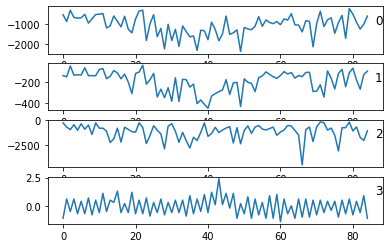

In [7]:
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# reframed = series_to_supervised(values, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.853890   0.758873   0.978056   0.041667  0.666667
2   0.696395   0.729884   0.880495   0.666667  0.291667
3   0.959203   0.982611   0.822238   0.291667  0.666667
4   0.793643   0.770359   0.936621   0.666667  0.208333
5   0.774194   0.778373   0.806712   0.208333  0.583333


In [9]:
# test
reframed.shape

(84, 5)

In [10]:
# split into train and test sets
values = reframed.values
n_train_num = 50
train = values[:n_train_num, :]
test = values[n_train_num:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 4) (50,) (34, 1, 4) (34,)


Train on 50 samples, validate on 34 samples
Epoch 1/50
50/50 - 3s - loss: 0.2150 - val_loss: 0.1082
Epoch 2/50
50/50 - 0s - loss: 0.1258 - val_loss: 0.0831
Epoch 3/50
50/50 - 0s - loss: 0.0908 - val_loss: 0.0862
Epoch 4/50
50/50 - 0s - loss: 0.0823 - val_loss: 0.0906
Epoch 5/50
50/50 - 0s - loss: 0.0799 - val_loss: 0.0912
Epoch 6/50
50/50 - 0s - loss: 0.0779 - val_loss: 0.0900
Epoch 7/50
50/50 - 0s - loss: 0.0760 - val_loss: 0.0881
Epoch 8/50
50/50 - 0s - loss: 0.0740 - val_loss: 0.0860
Epoch 9/50
50/50 - 0s - loss: 0.0720 - val_loss: 0.0837
Epoch 10/50
50/50 - 0s - loss: 0.0701 - val_loss: 0.0813
Epoch 11/50
50/50 - 0s - loss: 0.0681 - val_loss: 0.0788
Epoch 12/50
50/50 - 0s - loss: 0.0661 - val_loss: 0.0762
Epoch 13/50
50/50 - 0s - loss: 0.0640 - val_loss: 0.0735
Epoch 14/50
50/50 - 0s - loss: 0.0619 - val_loss: 0.0707
Epoch 15/50
50/50 - 0s - loss: 0.0599 - val_loss: 0.0680
Epoch 16/50
50/50 - 0s - loss: 0.0580 - val_loss: 0.0654
Epoch 17/50
50/50 - 0s - loss: 0.0561 - val_loss: 0.0

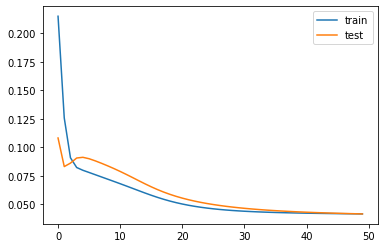

Test RMSE: 429.805


In [11]:
loss_fun = 'mse'
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss=loss_fun, optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig = plt.figure()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

fig.savefig('../output/%s_feature4_%.4f.png' % (loss_fun, rmse))

In [12]:
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]

# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)